In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Считываем JSON файл как словарь
with open('friends.json', 'r') as f:
    friends_dict = json.load(f)

# Создаем неориентированный граф при помощи библиотеки NetworkX
G = nx.Graph()

# Создаем датафрейм из данных CSV файла
df = pd.read_excel('dataframe.xlsx')

# Добавление вершин графа из значения колонки id датафрейма df
G.add_nodes_from(df['id'].values)

In [2]:
friends_dict = {int(key): value for key, value in friends_dict.items()}

# Добавление ребер в граф на основе словаря друзей
for user_id, friends in friends_dict.items():
    for friend_id in friends:
        if np.isin(friend_id, list(friends_dict.keys())):
            G.add_edge(user_id, friend_id)

In [3]:
# Вывод количества ребер графа
print("Количество ребер:", G.number_of_edges())
print("Количество вершин:", G.number_of_nodes())

Количество ребер: 14128
Количество вершин: 2085


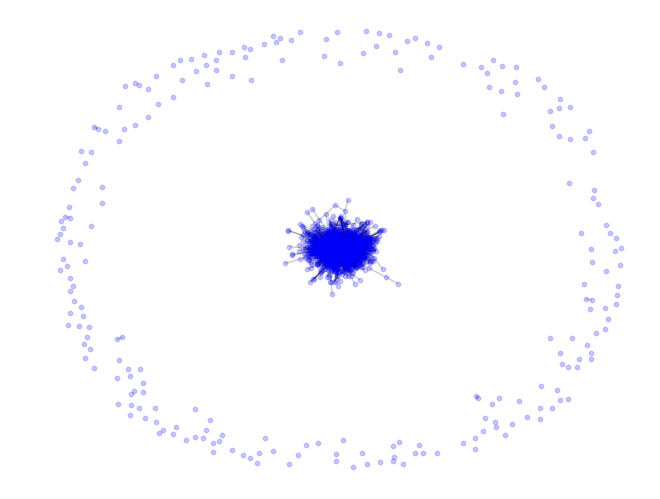

In [4]:
# Отрисовка графа
nx.draw(G, with_labels=False, alpha=0.2, width=1, node_size=10, node_color='blue')
plt.show()

In [5]:
# Вычисляем PageRank
pagerank = nx.pagerank(G)

# Сортируем вершины по значению PageRank в убывающем порядке
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Выводим список из 10 самых популярных вершин
top_vertices = [vertex for vertex, _ in sorted_pagerank[:10]]
print("Самые популярные вершины:", top_vertices)

Самые популярные вершины: [375852447, 201350084, 114941095, 615518884, 301403322, 330104901, 733177837, 159370664, 180779981, 189025553]


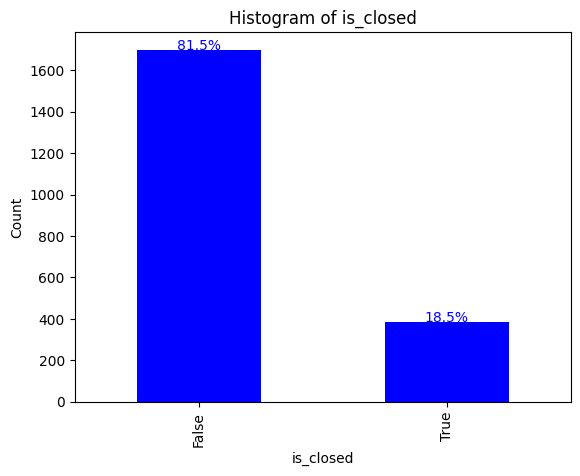

In [6]:
import matplotlib.pyplot as plt

# Группируем по колонке 'is_closed' и считаем количество значений True и False
counts = df['is_closed'].value_counts()

# Строим гистограмму
counts.plot(kind='bar', color = 'blue')

# Добавляем подписи осей и заголовок
plt.xlabel('is_closed')
plt.ylabel('Count')
plt.title('Histogram of is_closed')

# Добавляем подписи по количеству процентов от общего числа
total = counts.sum()
for i, count in enumerate(counts):
    percentage = count / total * 100
    plt.text(i, count + 1, f'{percentage:.1f}%', ha='center', color = 'blue')

# Отображаем гистограмму
plt.show()

In [7]:
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

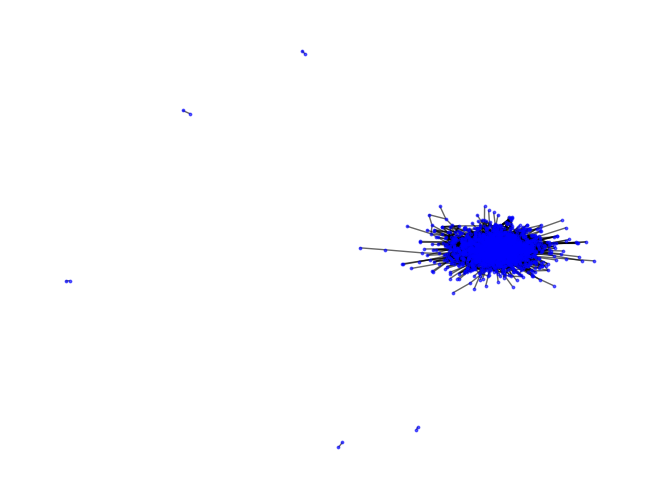

In [8]:
nx.draw(G, with_labels=False, alpha=0.6, width=1, node_size=3, node_color='blue')
plt.show()

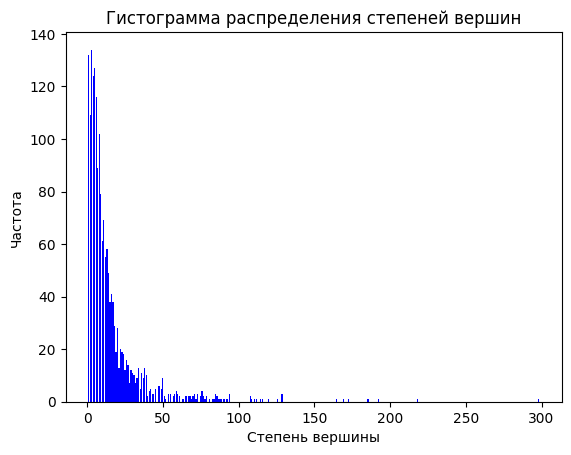

In [17]:
# Получение степеней вершин
degrees = [G.degree(node) for node in G.nodes()]

# Вывод гистограммы распределения степеней вершин
plt.hist(degrees, bins=max(degrees), align='left', rwidth=0.8, color = 'blue')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')
plt.title('Гистограмма распределения степеней вершин')
plt.show()

In [10]:
degrees = dict(G.degree())

# Сортировка вершин по наибольшей степени
top_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]

# Создание таблицы для вывода результатов
degree_table = pd.DataFrame(top_degrees, columns=['Вершина', 'Степень'])

# Вывод таблицы топ 10 вершин по наибольшей степени
degree_table

,Вершина,Степень
0,375852447,299
1,201350084,219
2,114941095,193
3,615518884,186
4,301403322,173
5,330104901,170
6,733177837,165
7,180779981,129
8,189025553,129
9,210930165,129


In [11]:
# Получение количества проходящих через вершины кратчайших путей
shortest_paths = dict(nx.betweenness_centrality(G))

# Сортировка вершин по количеству проходящих через них кратчайших путей
top_shortest_paths = sorted(shortest_paths.items(), key=lambda x: x[1], reverse=True)[:10]

# Создание таблицы для вывода результатов
shortest_paths_table = pd.DataFrame(top_shortest_paths, columns=['Вершина', 'Количество путей'])

# Вывод таблицы топ 10 вершин по количеству проходящих через них кратчайших путей
shortest_paths_table

,Вершина,Количество путей
0,375852447,0.119065
1,201350084,0.071997
2,615518884,0.050082
3,301403322,0.048285
4,114941095,0.047980
5,733177837,0.035160
6,330104901,0.034920
7,159370664,0.026503
8,189025553,0.025408
9,180779981,0.023029


In [12]:
result = pd.DataFrame()
result['По pagerank'] = top_vertices
result['По степени вершины'] = degree_table['Вершина']
result['По посредничеству'] = shortest_paths_table['Вершина']

result

,По pagerank,По степени вершины,По посредничеству
0,375852447,375852447,375852447
1,201350084,201350084,201350084
2,114941095,114941095,615518884
3,615518884,615518884,301403322
4,301403322,301403322,114941095
5,330104901,330104901,733177837
6,733177837,733177837,330104901
7,159370664,180779981,159370664
8,180779981,189025553,189025553
9,189025553,210930165,180779981


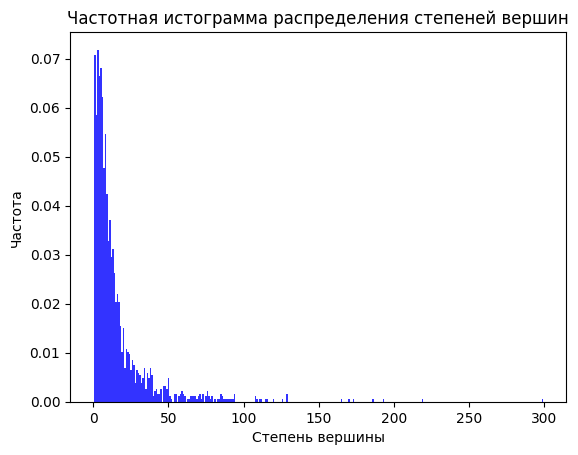

In [13]:
# Получаем распределение степеней вершин
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_sequence = list(filter(lambda x: x != 0, degree_sequence))

plt.hist(degree_sequence, bins=np.arange(max(degree_sequence)+2)-0.5, density=True, alpha=0.8, color='blue')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')
plt.title('Частотная истограмма распределения степеней вершин')

plt.show()

In [14]:
from scipy.stats import expon
from scipy.optimize import minimize

# Определяем функцию правдоподобия для экспоненциального распределения
def exponential_likelihood(degree_sequence, lambd):
    n = len(degree_sequence)
    sum_log_xi = sum(np.log(degree_sequence))
    return n * np.log(lambd) - lambd * sum_log_xi

# Ищем параметр lambda, при котором функция правдоподобия достигает максимума
def lambd(degree_sequence):
    result = minimize(lambda x: -exponential_likelihood(degree_sequence, x), x0=1.0, method='Nelder-Mead')
    lambda_opt = result.x[0]
    return lambda_opt

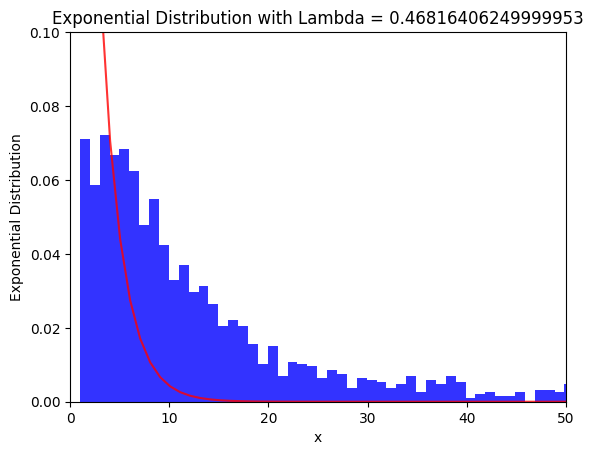

In [15]:
#Создаем pdf для экспоненциального распределения
def exponential_distribution(lmbda, x):
    return lmbda * np.exp(-lmbda * x)

# Задаем диапазон значений для построения графика
x = np.linspace(0, 100, 100)

# Вычисляем значения функции экспоненциального распределения для каждого значения x
y = exponential_distribution(lambd(degree_sequence), x)

# Строим график
plt.plot(x, y, color='r', alpha=0.8)
plt.hist(degree_sequence, bins=max(degree_sequence), density=True, alpha=0.8, color='blue')
plt.xlabel('x')
plt.ylabel('Exponential Distribution')
plt.title('Exponential Distribution with Lambda = {}'.format(lambd(degree_sequence))) 

plt.xlim(0, 50)
plt.ylim(0, 0.1)

plt.show()